# **Entrenamiento y evaluación de un sistema de edición de luz basado en Autoencoder**

_________________________________________________________________________________________________________________________________________________________________________________________________________
Angel Toledo Flores<br>
Ingeniero Mecánico Agrícola/Ingeniero en Sistemas Computacionales.<br>
**E-mail**: contactoangeltoledo@gmail.com<br>
 [Linkedin profile](https://www.linkedin.com/in/angel-toledo/) | [Portafolio de proyectos](https://resume.ingesaurio.com) <br> 
 [ DataSet: kagle](https://www.kaggle.com/code/shruthimshruthim/google-scrapped-image)



# Import img

## Kagle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kaggle kernels output shruthimshruthim/google-scrapped-image -p /path/to/dest

In [ ]:
! mkdir /content/image_input/

In [ ]:
!cp -R /path/to/dest/* /content/image_input

## Google

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/image_input

:

In [ ]:
!cp -R /content/gdrive/MyDrive/Automatic_light_editing/image_input/* /content/image_input

#Setup

In [ ]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import random 

from tensorflow.keras import layers 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

def splitDataset(PATH = '/content/image_input/*', test = 0.5):
  """
  Split the dataset in test and train and return list 
  """
  train_d = []
  test_d = glob.glob(PATH)
  for i in range(int(len(test_d)*test)):
    random_img = random.choice(test_d)
    train_d.append(random_img)
    test_d.remove(random_img)
  return train_d, test_d

def preprocess(array, px=128):
  """
  Normalizar la matriz suministrada y remodela en formato apropiado
  """
  array = array.astype("float32") / 255.0
  array = np.reshape(array, (len(array), px, px, 1))
  return array

def display(array1, array2,n=4,px=128):
  """
  Displays ten random images from each one of the supplied arrays.
  """

  indices = np.random.randint(len(array1), size=n)
  images1 = array1[indices, :]
  images2 = array2[indices, :]

  plt.figure(figsize=(20, 4))
  for i, (image1, image2) in enumerate(zip(images1, images2)):
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(image1.reshape(px, px))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(image2.reshape(px, px))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

In [ ]:
def extractHSV(list_path):
  """
  Lee la imagen de path en hsv
  """
  array_V = []
  array_hsv = []
  for element in list_path:
    image = cv.imread(element)
    #Convert BGR to HSV and extract V 
    hsv = cv.cvtColor(image,cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv)
    array_V.append(V)
    array_hsv.append(hsv)

  return array_hsv, array_V

In [ ]:
def Display(array1, array2, n=10):
  """
  Muestra las imagenes de cada array
  """
  #print(type(array1))
  #i = 0
  for i in range(len(array1)):   
    plt.imshow(cv.cvtColor(array1[i],cv.COLOR_HSV2RGB))
    plt.show()
    plt.imshow(cv.cvtColor(array2[i],cv.COLOR_HSV2RGB))
    plt.show()
    #i += 0
    if i >= n:
      break

In [ ]:

def updateHSV(hsv, V):
  """
   Sustituye V en hsv y devuelve hsv
  """
  V = V*255
  i = 0
  hsv = np.array(hsv)
  for element in V:
    hsv[i,:,:,2] = element[:,:,0]
    i += 1
  return hsv

def noise(array_V):
  """
  Modifica la luz aleatoriamente
  """
  array_VV = []
  diferencia = array_V
  for i in range(len(array_V)):
    image_noise = array_V[i] * (0.1 * random.choice([i for i in range(3,17) if i not in [9,10,11]]) )   #random.uniform(0.3, 1.7) #random.uniform(0.3, 1.7)
    image_noise = np.clip(image_noise, 0, 1.0)
    array_VV.append(image_noise)
  return array_VV

#Prepare the data

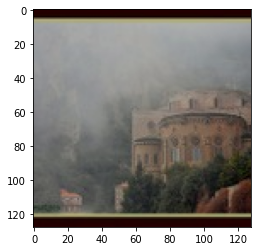

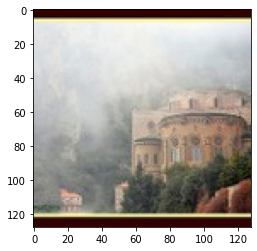

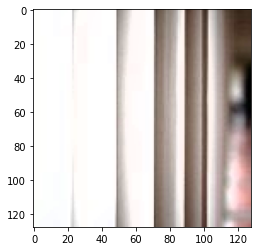

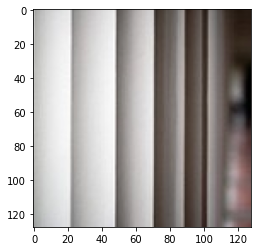

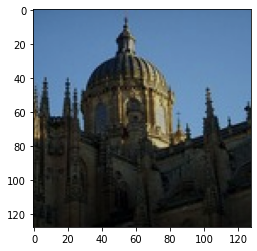

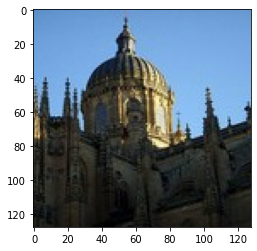

In [ ]:


dataset_train, dataset_test = splitDataset()
hsv_train, train_data = extractHSV(dataset_train)
hsv_test, test_data = extractHSV(dataset_test)

# Normalize and reshape the data
train_data = preprocess(np.array(train_data),px=128)
test_data = preprocess(np.array(test_data),px=128)


# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_train_data = np.array(noisy_train_data)
noisy_test_data = noise(test_data)
noisy_test_data = np.array(noisy_test_data)

HSV_TRAIN_NOISE = updateHSV(np.array(hsv_train), noisy_train_data)
HSV_TEST_NOISE = updateHSV(np.array(hsv_test), noisy_test_data)
Display(HSV_TRAIN_NOISE, np.array(hsv_train), n=10)



# Buil autoencoder

## Autoencoder Simple


In [ ]:
import keras
#from keras import layers
import keras
from keras import layers

input = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 32)       9248  

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

# Inferencias

<class 'numpy.ndarray'>
(10, 128, 128, 1)


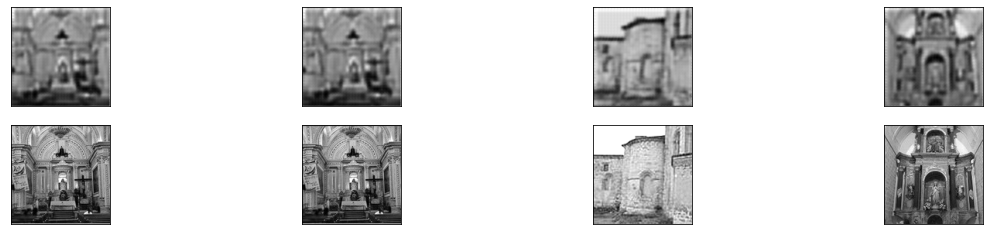

<class 'numpy.ndarray'>
(10, 128, 128, 1)


In [ ]:
predictions = autoencoder.predict(noisy_test_data)
print(type(predictions))
print(np.shape(predictions))

HSV_PREDICTS = updateHSV(np.array(hsv_test), predictions)
HSV_NOISE = updateHSV(np.array(hsv_test), noisy_test_data)

display(predictions,noisy_test_data)
#plt.imshow(predictions[1])
#plt.show()
#plt.imshow(noisy_test_data[1])
#plt.show()

print(type(np.array(noisy_test_data)))
print(np.shape(noisy_test_data))
#Display(HSV_NOISE, HSV_PREDICTS, n=2)
#display(noisy_test_data, predictions)